# Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file training.csv), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the testing documents. This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.


In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 

from nltk.tokenize import WordPunctTokenizer
from nltk.util import ngrams
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from textblob import TextBlob

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()


In [3]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])
test_path ='test.csv'
test_data = pd.read_csv(test_path, skip_blank_lines = True, header=None, names=['Line','Character','Gender'])

# Inspect
all_train_data

,Line,Character,Gender
0,Someone had fun.,SEAN,male
1,"It's no problem, honestly. Go on, go and open the launderette. Leave it with me.",SHIRLEY,female
2,Last night was better than ever. What's all this? Anything interesting?,MAX,male
3,Have you checked the answerphone? Any calls?,IAN,male
4,Oscar's asleep.,MAX,male
...,...,...,...
10108,"What's going on Gal? What's going on? I don't understand mate. You said you were gonna go and get her, you promised...",MINTY,male
10109,Am I mad? Have I completely lost it?,TANYA,female
10110,You're late.,JACK,male
10111,Ask your psycho Ex.,ROXY,female


In [4]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
print('Raw Data: ',np.shape(all_train_data))
idx = int(0.9 * np.shape(all_train_data)[0])
train_data = all_train_data[:idx]
val_data = all_train_data[idx:]
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (10113, 3)
Train set:  (9101, 3)
Validation set:  (1012, 3)


In [5]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [6]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SEAN': 360, 'SHIRLEY': 360, 'MAX': 360, 'IAN': 360, 'MINTY': 360, 'RONNIE': 360, 'STACEY': 360, 'JANE': 360, 'PHIL': 360, 'CLARE': 359, 'TANYA': 360, 'HEATHER': 360, 'GARRY': 308, 'BRADLEY': 292, 'CHRISTIAN': 357, 'STEVEN': 268, 'ROXY': 360, 'JACK': 360}
Num. Characters:  18 

SEAN Number of Words:  3629
SHIRLEY Number of Words:  4023
MAX Number of Words:  4627
IAN Number of Words:  4165
MINTY Number of Words:  3914
RONNIE Number of Words:  3528
STACEY Number of Words:  3979
JANE Number of Words:  3818
PHIL Number of Words:  3950
CLARE Number of Words:  4311
TANYA Number of Words:  4092
HEATHER Number of Words:  4040
GARRY Number of Words:  3599
BRADLEY Number of Words:  2865
CHRISTIAN Number of Words:  3979
STEVEN Number of Words:  2485
ROXY Number of Words:  3824
JACK Number of Words:  4110
total words 68938


# Q1. Improvement of pre-processing
A number of pre-processing techniques were applied in a number of permutations. The pre-processing techniques were evaluated were:
- Normalisation of words
- Various types of tokenisation such as WhitespaceTokenizer() and word_tokenize()
- Punctuation removal
- Stopword removal
- Lemmatisation
- Stemming


In [7]:
# initialising stopwords and NER
en_stopwords = stopwords.words("english")
ner = spacy.load("en_core_web_sm")

def pre_process(text, punc=False, stem=False, lemm=False, 
                stopwords=False, norm=False, NER=False, 
                POS=False, whitespace=False, sentiment=False):


    # whitespace tokenise text
    if whitespace:
        ws_tk = WhitespaceTokenizer()
        tokens = ws_tk.tokenize(text)
    else:
        tokens = word_tokenize(text)

    # puncuation removal
    if punc:
        text = ' '.join(tokens)
        no_punc_text = re.sub(r'[^\w\s]', ' ', text)
        tokens = no_punc_text.split()
        
    # normalise words
    if norm is True:
        tokens = [word.lower() for word in tokens]
    

    # copy of preprocessed normalised tokens without stemming, lemmatisation or stopword removal
    pre_norm_tokens = tokens.copy()
    
    # stopword removal
    if stopwords is not None:
        tokens = [word for word in tokens if word not in en_stopwords]
    
    # lemmatiser
    if lemm:
        lemmat = WordNetLemmatizer()
        tokens = [lemmat.lemmatize(word) for word in tokens]

     # stemming
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
        
    # EXTRA FEATURES
    token_marker = ['END_OF_TOKENS']
    tokens += token_marker
    
    # NER
    if NER:
        ner_doc = ner(text)
        ner_tags = [[x.text, x.label_] for x in ner_doc.ents]
        ner_list = ['__NER__'+ x[0]+ ' _' + x[1]+ '_' for x in ner_tags]
        tokens += ner_list

    # Sentiment
    if sentiment:
        pol = ['__SENT_'+ str(TextBlob(text).sentiment.polarity)]
        sub = ['__SENT_'+ str(TextBlob(text).sentiment.subjectivity)]
        tokens += pol
        tokens += sub

    # POS tags
    if POS:
        POS_text_tags = ['__POS__'+ token +'_' + tag for token, tag in pos_tag(pre_norm_tokens)]
        tokens +=POS_text_tags
        
    return tokens

### Example of various combinations of pre-processing features

In [8]:
s1 = "I love running in Brockwell Park on Tuesdays."

print(s1)
print()
print(pre_process(s1, sentiment=True, norm=True))
print()
print(pre_process(s1, NER=True, POS=True, punc=True, sentiment=True, norm=True))
print()
print(pre_process(s1, stopwords=True, stem=True, whitespace=True))


I love running in Brockwell Park on Tuesdays.

['love', 'running', 'brockwell', 'park', 'tuesdays', '.', 'END_OF_TOKENS', '__SENT_0.5', '__SENT_0.6']

['love', 'running', 'brockwell', 'park', 'tuesdays', 'END_OF_TOKENS', '__NER__Brockwell Park _GPE_', '__NER__Tuesdays _DATE_', '__SENT_0.5', '__SENT_0.6', '__POS__i_JJ', '__POS__love_VBP', '__POS__running_VBG', '__POS__in_IN', '__POS__brockwell_NN', '__POS__park_NN', '__POS__on_IN', '__POS__tuesdays_NNS']

['I', 'love', 'run', 'brockwel', 'park', 'tuesdays.', 'END_OF_TOKENS']


In [9]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc,punc=True, norm=True, lemm=True, sentiment=True)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]


# Q2. Improvement of feature extraction
The additional features that were extracted from the text were:
- Named Entity Recognition (NER)
- Part-of-Speech tagging (POS)
- Sentiment analysis
- Bigrams

In order to perform NER and sentiment analysis on the text, these features were implemented before the text was tokenised. The POS tags were also implemented before stemming or lemmatisation on the normalised tokens.

For the sentiment analysis, the polarity and subjectivity across the whole text were determined. The average of the characters sentiment attributes from the training corpus were calculated. The sentiments from the unseen data was then compared to the averages were classified in a binary manner dependending on whether the sentiment exceeded the average values.



In [10]:
tb_pols = []
for name in train_character_docs.keys():
    txt = train_character_docs[name]
    tb_pols.append(TextBlob(txt).sentiment.polarity)

tb_subs = []
for name in train_character_docs.keys():
    txt = train_character_docs[name]
    tb_subs.append(TextBlob(txt).sentiment.subjectivity)
sent_df = pd.DataFrame(np.column_stack((tb_pols,tb_subs)), columns=['polarity', 'subjectivity'])
sent_df

,polarity,subjectivity
0,0.096912,0.442251
1,0.103894,0.493575
2,0.091057,0.526998
3,0.109444,0.512593
4,0.053273,0.517321
5,0.099382,0.453965
6,0.063416,0.520591
7,0.059804,0.478323
8,0.089488,0.503396
9,0.092942,0.506289


In [11]:
pol_avg = sent_df.mean()[0]
sub_avg = sent_df.mean()[1]

print(f'In the training data, the mean of the polarity was {pol_avg:0.4f}')
print(f'In the training data, the mean of the subjectivity was {sub_avg:0.4f}')

In the training data, the mean of the polarity was 0.0912
In the training data, the mean of the subjectivity was 0.5016


In [12]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    
    tokens = character_doc
    
    # the tokens were split on the marker below
    split_point = tokens.index('END_OF_TOKENS')

    # preprocessed tokens and extra feature tokens
    # bigrams taken from preprocessed tokens only, not extra feature tokens
    pp_tokens = tokens[:split_point]  
    ef_tokens = tokens[split_point+1:]  

    # binary sentiment classification
    if 'sentiment' in extra_features:
        initial_tokens = tokens
        sent_list = [x for x in initial_tokens if x.startswith('__SENT_')]

        # sentiment tokens removed
        tokens = [x for x in initial_tokens if x not in sent_list]
        # sentiment tokens converted to floats from str
        sent_list = [x.replace('__SENT_', '') for x in sent_list]
        pol = float(sent_list[0])
        sub = float(sent_list[1])

    # tokens counted
    counts = Counter(tokens)  
    counts = dict(counts)
    
    # sentiment classification
    if 'sentiment' in extra_features:
        if pol > pol_avg:
            counts['__POSITIVE__'] = 1
        else:
            counts['__POSITIVE__'] = 0

        if sub > sub_avg:
            counts['__SUBJECTIVE__'] = 1
        else:
            counts['__SUBJECTIVE__'] = 0

    # Bigrams
    if "bigrams" in extra_features:
        bigram_tuples = list(ngrams(pp_tokens,2))
        bigrams = [x[0]+'_'+x[1] for x in bigram_tuples]
        for bigram in bigrams:
            if bigram in counts.keys():
                counts[bigram] +=1
            else:
                counts[bigram] = 1

    # remove _EOL_ tokens as features 
#     del counts['_eol_']
    

    return counts  

In [13]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
tfidf_transformer = TfidfTransformer()


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, extra_features=['sentiment']) for name, doc in corpus])
        doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc,extra_features=['sentiment']) for name, doc in corpus])
        tfidf_feature_matrix = tfidf_transformer.fit_transform(doc_feature_matrix)
    else:
        doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc,extra_features=['sentiment']) for name, doc in corpus])
        tfidf_feature_matrix = tfidf_transformer.transform(doc_feature_matrix)
#     training_feature_matrix[0].toarray()
    return tfidf_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [14]:
training_feature_matrix

<18x3992 sparse matrix of type '<class 'numpy.float64'>'
	with 12325 stored elements in Compressed Sparse Row format>

In [15]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, punc=True, norm=True, lemm=True, sentiment=True)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'IAN': 40, 'STACEY': 40, 'JANE': 40, 'SEAN': 40, 'CLARE': 40, 'MAX': 40, 'TANYA': 40, 'JACK': 40, 'SHIRLEY': 40, 'RONNIE': 40, 'MINTY': 39, 'GARRY': 32, 'STEVEN': 30, 'BRADLEY': 40, 'ROXY': 40, 'CHRISTIAN': 40, 'HEATHER': 40, 'PHIL': 40}
Num. Characters:  18 

IAN Num of Words:  611
STACEY Num of Words:  409
JANE Num of Words:  503
SEAN Num of Words:  414
CLARE Num of Words:  512
MAX Num of Words:  411
TANYA Num of Words:  399
JACK Num of Words:  434
SHIRLEY Num of Words:  419
RONNIE Num of Words:  362
MINTY Num of Words:  555
GARRY Num of Words:  387
STEVEN Num of Words:  312
BRADLEY Num of Words:  509
ROXY Num of Words:  376
CHRISTIAN Num of Words:  517
HEATHER Num of Words:  543
PHIL Num of Words:  411
total words 8084


In [16]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [17]:
val_feature_matrix

<18x3992 sparse matrix of type '<class 'numpy.float64'>'
	with 2412 stored elements in Compressed Sparse Row format>

In [18]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [19]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [20]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

mean rank 1.1666666666666667
mean cosine similarity 0.8665442080125233
16 correct out of 18 / accuracy: 0.8888888888888888


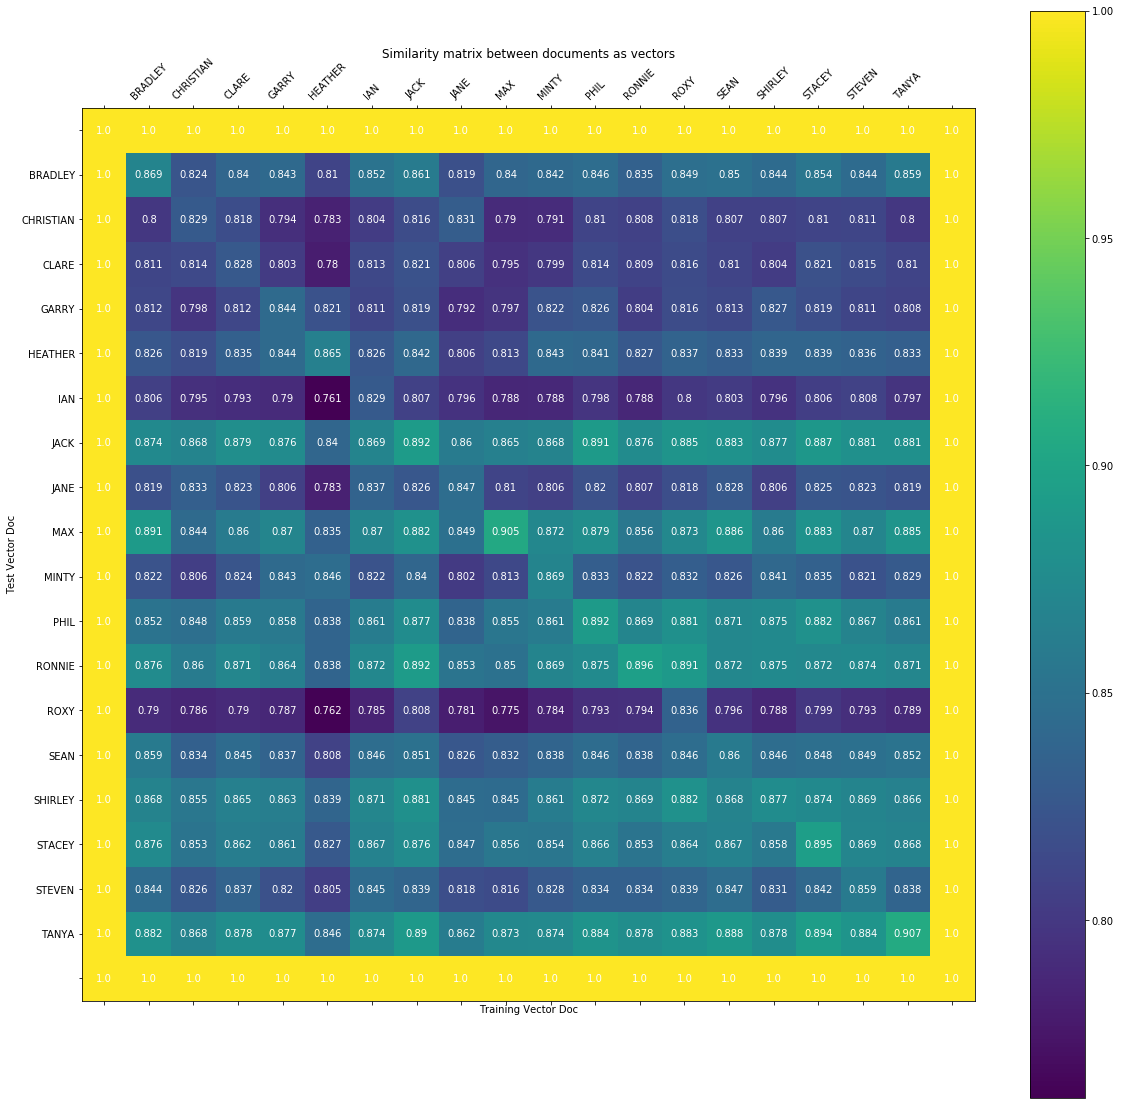

In [21]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
plot_heat_map_similarity(df)

In [22]:
print(f'{mean_rank:.4f}')
print(f'{mean_cosine_simliarity:.4f}')
print(f'{acc:.4f}')

1.1667
0.8665
0.8889


# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, including those you used to optimize Gender classification on this data in Assignment 3, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **18**. Initially the code in this template achieves a mean rank of 2.89 and accuracy of 0.5 on the validation set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.

As you develop your methods, you should be able to see which character representations are being confused with others and the extent by looking at the simliarity heatmap representation of the dataframe generated by the `plot_heat_map_similarity` function above. Note the effect/improvement in mean rank with each technique you try.


# Q1: Effects of pre-processing techniques

Below is a dataframe of various permutations of the different preprocessing operations. From the results it can be determined that normalisation is fundamental to the preprocessing. The efficacy of the other preprocessing techniques is less clear, although the removal of punctuation is a noteworthy effective technique.

In [23]:
pp1 = np.array(('norm=True, punc=True, stopwords=True', 1.444, 0.945, 0.722))
pp2 = np.array(('norm=True, punc=True, lemm=True', 1.222, 0.949, 0.889))
pp3 = np.array(('norm=True, punc=True, stem=True', 1.444, 0.948, 0.777))
pp4 = np.array(('norm=True, whitespace=True', 1.278, 0.940, 0.889))
pp5 = np.array(('norm=True, punc=True, stopwords=True, whitespace=True', 1.222, 0.948, 0.833))
pp6 = np.array(('lemm=True, stopwords=True', 1.778, 0.967, 0.722))
pp7 = np.array(('punc=True, stopwords=True', 1.889, 0.946, 0.778))
pp_arrays = np.column_stack((pp1, pp2, pp3, pp4, pp5, pp6, pp7))

In [24]:
pp_df = pd.DataFrame(pp_arrays).T
pp_df.columns=['preprocessing function arguments', 'mean rank', 'mean cosine similarity', 'accuracy']
pp_df

,preprocessing function arguments,mean rank,mean cosine similarity,accuracy
0,"norm=True, punc=True, stopwords=True",1.444,0.945,0.722
1,"norm=True, punc=True, lemm=True",1.222,0.949,0.889
2,"norm=True, punc=True, stem=True",1.444,0.948,0.777
3,"norm=True, whitespace=True",1.278,0.94,0.889
4,"norm=True, punc=True, stopwords=True, whitespace=True",1.222,0.948,0.833
5,"lemm=True, stopwords=True",1.778,0.967,0.722
6,"punc=True, stopwords=True",1.889,0.946,0.778


# Q2. Improve feature extraction (20 marks)
Use the feature extraction techniques you have learned, including those you used to optimize Gender classification in Assignment 3, to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q2: Feature extraction optimisation

The effects of the different features on the mean rank and the accuracy on the validation set are shown below. The inclusion of POS tags as features appears to have a negative impact on the accuracy and the mean rank, whilst NER and sentiment were found to be an improvement. The impact of bigrams was less conclusive, with some measures found to be an improvement whilst others were not an improvement.

In [25]:

fe1 = np.array(('punc=True, norm=True, POS=True',1.8333,0.9054,0.6111))
fe2 = np.array(('punc=True, norm=True, sentiment=True', 1.2222,0.9480,0.8889))
fe3 = np.array(('punc=True, norm=True, NER=True',1.2222, 0.9438, 0.8889))
fe4 = np.array(('punc=True, norm=True, bigrams',1.2778,0.9139,0.7778))
fe5 = np.array(('punc=True, norm=True, NER=True, sentiment=True',1.2778, 0.9405, 0.8333))
fe6 = np.array(('punc=True, norm=True,stopwords=True, NER=True, POS=True, sentiment=True', 1.7222, 0.9033, 0.6667))

fe7 = np.array(('punc=True, norm=True, NER=True, POS=True, sentiment=True',1.7222,0.9033,0.6667))
fe8 = np.array(('punc=True, norm=True, lemm=True, sentiment=True', 1.1667, 0.9483, 0.8889))

fe9 = np.array(('punc=True, norm=True, NER=True, POS=True, sentiment=True, bigrams',1.6111,0.8891,0.6667))



ef_arrays = np.column_stack((fe1, fe2, fe3, fe4, fe5, fe6,fe7, fe8, fe9))
ef_df = pd.DataFrame(ef_arrays).T
ef_df.columns=['extra features function arguments', 'mean rank', 'mean cosine similarity', 'accuracy']
ef_df

,extra features function arguments,mean rank,mean cosine similarity,accuracy
0,"punc=True, norm=True, POS=True",1.8333,0.9054,0.6111
1,"punc=True, norm=True, sentiment=True",1.2222,0.948,0.8889
2,"punc=True, norm=True, NER=True",1.2222,0.9438,0.8889
3,"punc=True, norm=True, bigrams",1.2778,0.9139,0.7778
4,"punc=True, norm=True, NER=True, sentiment=True",1.2778,0.9405,0.8333
5,"punc=True, norm=True,stopwords=True, NER=True, POS=True, sentiment=True",1.7222,0.9033,0.6667
6,"punc=True, norm=True, NER=True, POS=True, sentiment=True",1.7222,0.9033,0.6667
7,"punc=True, norm=True, lemm=True, sentiment=True",1.1667,0.9483,0.8889
8,"punc=True, norm=True, NER=True, POS=True, sentiment=True, bigrams",1.6111,0.8891,0.6667


# Q3. Improve the vectorization method (20 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q3: Vectorization improvement
Using no additional features and only normalisation and punctuation removal as preprocessing features, the mean rank was 1.4444 and with an accuracy of 0.6667 was found by the model. To improve the vectorization of the model, a tf-idf transformer was applied.

With a tf-idf transformer also using the pre-processing features given above, there was a significant improvement to the model. The mean rank achieved a score of 1.1667 whilst the accuracy improved to 0.8889. 

Different settings of the count of the CountVectorizer were implemented such as minimum document frequency and maximum document frequency, however there were no significant improvements found. Subsequently, the tf-idf transformation was selected as the best method for the model.

# Q4. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

# Q4: Best vector representation

A number of various combinations of preprocessing techniques, extra features and vectorization  parameters were considered. In almost all cases, POS tags were found to worsen the score, whilst the effect of bigrams was tempramental. As the efficacy of bigrams was unclear, they were not used in the model.

The removal of punctuation, normalisation and lemmatization of the text was found to have the best signicant improvement of the preprocessing features. Of the extra features, NER had some improvement, but as with the bigrams this was not consistent. The only extra feature that was found to be part of the best model was the sentiment analysis. 

The features that made up the best model were:
- punctuation removal
- normalisation
- lemmatisation
- sentiment analysis

In [26]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc, punc=True, norm=True, lemm=True, sentiment=True)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer() #  initialize a corpusVectorizor which will output sparse vectors from dicts
tfidf_transformer = TfidfTransformer()
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc, punc=True, norm=True, lemm=True, sentiment=True)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)


lines per character {'SEAN': 400, 'SHIRLEY': 400, 'MAX': 400, 'IAN': 400, 'MINTY': 400, 'RONNIE': 400, 'STACEY': 400, 'JANE': 400, 'PHIL': 400, 'CLARE': 400, 'TANYA': 400, 'HEATHER': 400, 'GARRY': 340, 'BRADLEY': 332, 'CHRISTIAN': 397, 'STEVEN': 298, 'ROXY': 400, 'JACK': 400}
Num. Characters:  18 

SEAN Number of Words:  3949
SHIRLEY Number of Words:  4427
MAX Number of Words:  5098
IAN Number of Words:  4730
MINTY Number of Words:  4374
RONNIE Number of Words:  3903
STACEY Number of Words:  4370
JANE Number of Words:  4154
PHIL Number of Words:  4322
CLARE Number of Words:  4837
TANYA Number of Words:  4605
HEATHER Number of Words:  4484
GARRY Number of Words:  3986
BRADLEY Number of Words:  3374
CHRISTIAN Number of Words:  4496
STEVEN Number of Words:  2797
ROXY Number of Words:  4196
JACK Number of Words:  4564
total words 76666
lines per character {'STACEY': 40, 'RONNIE': 40, 'STEVEN': 37, 'TANYA': 40, 'MAX': 40, 'ROXY': 40, 'IAN': 40, 'JANE': 40, 'JACK': 40, 'CLARE': 31, 'PHIL': 4